# Cross-resonance gate between two transmons: leakage scan

In [27]:
import numpy as np
import scipy.integrate
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pysqkit
from pysqkit import QubitSystem, Qubit
from pysqkit.drives.pulse_shapes import gaussian_top
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem
from pysqkit.solvers.solvkit import integrate
from pysqkit.util.hsbasis import pauli_by_index
from pysqkit.solvers import solvkit
from pysqkit.drives.pulse_shapes import gaussian_top
import qutip
from typing import List, Dict, Callable
import multiprocessing
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json
import cmath
import util_tt_cr

from IPython.display import display, Latex

In [28]:
def func_to_minimize(
    pulse_time: list,
    t_rise: float,
    cr_coeff: float
) -> float:
    step = 1e-3
    n_points = int(pulse_time[0]/step)
    times = np.linspace(0, pulse_time[0], n_points)
    pulse = gaussian_top(times, t_rise, pulse_time[0])
    integral = scipy.integrate.simpson(2*np.pi*cr_coeff*pulse, times)
    return np.abs(integral - np.pi/4)   

def cr_gate_time(
    cr_coeff: float
):
    return 1/(2*np.pi*cr_coeff)*np.pi/4

In [29]:
def get_leakage(
    transm_freq: float
) -> dict:
    temperature = 0.020 #0.020 # K
    thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
    d_comp = 4

    control_freq = 5.0

    #Transmon
    levels_t = 3
    transm_t = pysqkit.qubits.SimpleTransmon(
        label='T', 
        max_freq=transm_freq, 
        anharm=-0.3,
        diel_loss_tan=0.3*1e-6, 
        env_thermal_energy=thermal_energy,    
        dim_hilbert=levels_t,
        dephasing_times=None 
    )

    transm_c = pysqkit.qubits.SimpleTransmon(
        label='C', 
        max_freq=control_freq, 
        anharm=-0.3,
        diel_loss_tan=0.3*1e-6, #set to zero to check d_1 L1 = d_2 L2
        env_thermal_energy=thermal_energy,    
        dim_hilbert=levels_t,
        dephasing_times=None #parameters_set[p_set]["dephasing_times_t"]
    )

    # We also add a drive on the fluxonium
    transm_c.add_drive(
        pysqkit.drives.microwave_drive,
        label='cr_drive',
        pulse=pysqkit.drives.pulses.cos_modulation,
        pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
    )

    d_leak = levels_t**2 - d_comp

    jc = 0.002
    coupled_sys = transm_t.couple_to(transm_c, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)


    states_label = coupled_sys.all_state_labels()
    states_dict = coupled_sys.states_as_dict(as_qobj=True)
    
    state_label = ["00", "01", "10", "11"]
    comp_states = {}
    for label in state_label:
        state_tmp = coupled_sys.state(label)[1]
        loc = np.argmax(np.abs(state_tmp))
        phase = cmath.phase(state_tmp[loc])
        state_tmp = np.exp(-1j*phase)*state_tmp
        comp_states[label] = state_tmp
    
    eps = 0.03
    cr_coeff = np.abs(util_tt_cr.mu_yz_sw(jc, eps, transm_t, transm_c))
    freq_drive = transm_t.max_freq
    t_rise = 10.0 # [ns]

    t_gate_0 = [cr_gate_time(cr_coeff)]

    args_to_pass = (t_rise, cr_coeff) 

    start = time.time()

    minimization_result = minimize(func_to_minimize, t_gate_0, args=args_to_pass)

    end = time.time()

    t_gate = minimization_result['x'][0] 
    pts_per_drive_period = 10

    #t_tot = 135

    nb_points = int(t_gate*freq_drive*pts_per_drive_period)
    tlist = np.linspace(0, t_gate, nb_points)

    coupled_sys['C'].drives['cr_drive'].set_params(phase=0, time=tlist, rise_time=t_rise, pulse_time=t_gate,
                                                   amp=eps, freq=freq_drive)

    simu_opt = qtp.solver.Options()
    simu_opt.atol = 1e-12
    simu_opt.rtol = 1e-10

    env_syst = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, 
                                          options=simu_opt, with_noise=False)
    
    env_syst_noisy = pysqkit.tomography.TomoEnv(system=coupled_sys, time=2*np.pi*tlist, 
                                          options=simu_opt, with_noise=True)
    
    comp_states_list = []
    for key in comp_states.keys():
        comp_states_list.append(comp_states[key])
    
    avg_leakage = env_syst.leakage(comp_states_list)
    
    res={}
    res["transm_freq"] = transm_freq
    res["gate_time"] = t_gate
    res["eps"] = eps
    res["L1"] = avg_leakage
    
    return res
    

In [30]:
start = time.time()

get_leakage(4.8)

end = time.time()

print("Computation time: {} s".format(end - start))

Computation time: 5.400928258895874 s


In [31]:
n_points = 50
n_processes = 4
bound = 0.03
freq_list = np.linspace(4.7 + bound, 5.0 - bound, n_points)

start = time.time()

pool = multiprocessing.Pool(processes=n_processes)

result = pool.map(get_leakage, freq_list, chunksize=int(n_points//n_processes))

pool.close()
pool.join()

end=time.time()

print("Computation time: {} s".format(end - start))

Computation time: 94.52336001396179 s


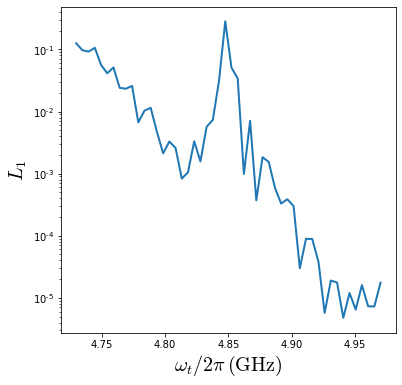

In [32]:
def plot_leakage_scan(
    result: dict,
    opt={'fs': 20, 'lw': 2.0, 'ls': 16, 'fsl':18, "ms":8}
):
    n_points = len(result)
    freqs = [res["transm_freq"] for res in result]
    l1 = [res["L1"] for res in result]
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.semilogy(freqs, l1, linewidth=opt["lw"])
    ax.set_xlabel("$\omega_t /2\pi \, (\mathrm{GHz})$", fontsize=opt["fs"])
    ax.set_ylabel("$L_1$", fontsize=opt["fs"])
    plt.show()
    
plot_leakage_scan(result)

In [35]:
save = True
if save:
    with open("tmp/cr_leakage.txt", "w") as fp:
        json.dump(result, fp)